In [1]:
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.varmax import VARMAX
from statsmodels.tsa.api import VAR
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler,RobustScaler,MinMaxScaler
from scipy.stats import pearsonr
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
from pandas.plotting import lag_plot
from pandas.plotting import autocorrelation_plot
from matplotlib import pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, grangercausalitytests
import math as math
from scipy.stats import boxcox
from random import randrange
from random import seed
from random import random
from random import gauss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.api import VAR
from scipy.stats import pearsonr
from statsmodels.tsa.statespace.varmax import VARMAX

In [2]:
df_var = pd.read_csv("synthetic_weather_data_wo_label.csv",header=0, index_col=0, parse_dates=True)

In [3]:
# Test for stationary
ad_fuller_test_temperature = adfuller(df_var['temperature'])
print('ad_fuller_test on temperature')
print(f'ADF Statistic: {ad_fuller_test_temperature[0]}')
print(f'p-value: {ad_fuller_test_temperature[1]}')

ad_fuller_test_pressure = adfuller(df_var['pressure'])
print('ad_fuller_test on pressure')
print(f'ADF Statistic: {ad_fuller_test_pressure[0]}')
print(f'p-value: {ad_fuller_test_pressure[1]}')

ad_fuller_test_humidity = adfuller(df_var['humidity'])
print('ad_fuller_test on humidity')
print(f'ADF Statistic: {ad_fuller_test_humidity[0]}')
print(f'p-value: {ad_fuller_test_humidity[1]}')

ad_fuller_test on temperature
ADF Statistic: -14.534913289227394
p-value: 5.258250094577109e-27
ad_fuller_test on pressure
ADF Statistic: -14.902048605743865
p-value: 1.5019298946503847e-27
ad_fuller_test on humidity
ADF Statistic: -12.562418655330086
p-value: 2.0884646331942584e-23


In [4]:
df_var.head()

,temperature,pressure,humidity
date,,,
2008-01-01,-0.09,987.23,51.10
2008-01-02,-0.96,987.06,51.17
2008-01-03,-0.65,987.82,51.13
2008-01-04,-0.68,986.95,50.94
2008-01-05,-0.42,988.15,51.30


In [5]:
df_var.tail()

,temperature,pressure,humidity
date,,,
2022-12-27,-1.93,984.39,49.59
2022-12-28,-1.54,984.69,50.18
2022-12-29,-1.44,985.60,50.98
2022-12-30,-1.87,985.40,50.24
2022-12-31,-1.26,986.75,50.38


In [6]:
# Not on same scale and need to split the data to the train and test part 
Ntest = 1096   # 3 year
train= df_var.iloc[:-Ntest].copy()
test= df_var.iloc[-Ntest:].copy()

scaler_temp= RobustScaler()
train['ScaledTemp'] = scaler_temp.fit_transform(train[['temperature']])
test['ScaledTemp'] = scaler_temp.transform(test[['temperature']])

scaler_humid= RobustScaler()
train['ScaledHumid'] = scaler_humid.fit_transform(train[['humidity']])
test['ScaledHumid'] = scaler_humid.transform(test[['humidity']])

scaler_pressure= RobustScaler()
train['ScaledPressure'] = scaler_pressure.fit_transform(train[['pressure']])
test['ScaledPressure'] = scaler_pressure.transform(test[['pressure']])

train_idx = df_var.index <=train.index[-1]
test_idx = df_var.index > train.index[-1]

df_var.loc[train_idx, 'ScaledTemp']= train['ScaledTemp']
df_var.loc[test_idx, 'ScaledTemp']= test['ScaledTemp']

df_var.loc[train_idx, 'ScaledHumid']= train['ScaledHumid']
df_var.loc[test_idx, 'ScaledHumid']= test['ScaledHumid']

df_var.loc[train_idx, 'ScaledPressure']= train['ScaledPressure']
df_var.loc[test_idx, 'ScaledPressure']= test['ScaledPressure']

<AxesSubplot: xlabel='date'>

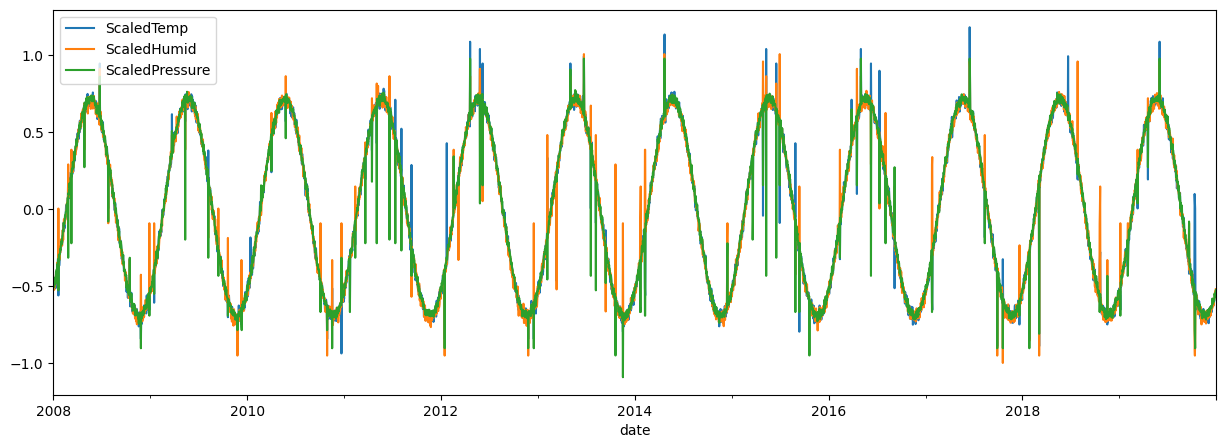

In [7]:
cols = ['ScaledTemp', 'ScaledHumid', 'ScaledPressure']
train[cols].plot(figsize=(15,5))

<AxesSubplot: xlabel='date'>

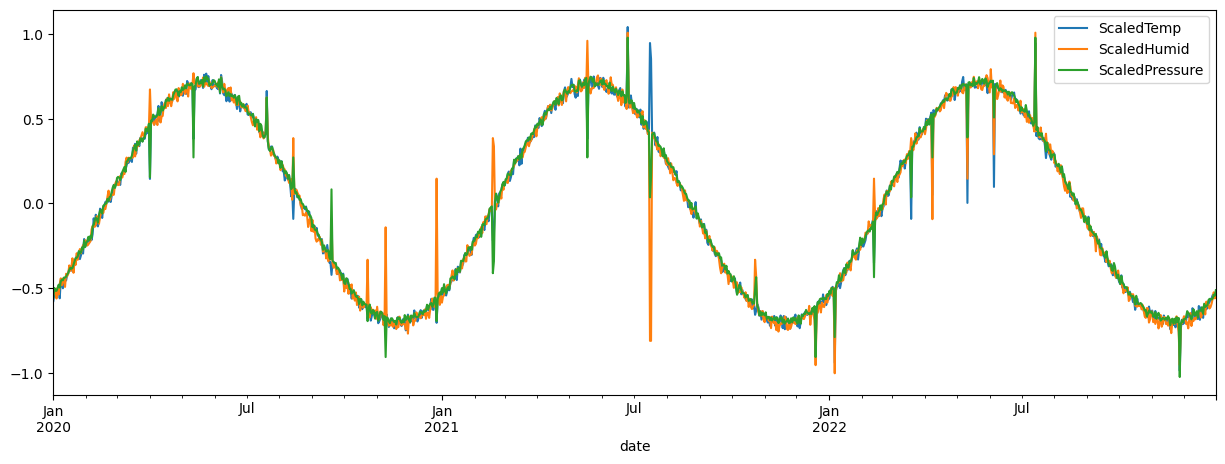

In [8]:
cols = ['ScaledTemp', 'ScaledHumid', 'ScaledPressure']
test[cols].plot(figsize=(15,5))

In [9]:
train[cols].head()

,ScaledTemp,ScaledHumid,ScaledPressure
date,,,
2008-01-01,-0.472419,-0.518412,-0.500118
2008-01-02,-0.513437,-0.515065,-0.504121
2008-01-03,-0.498821,-0.516978,-0.486226
2008-01-04,-0.500236,-0.526064,-0.506711
2008-01-05,-0.487977,-0.508847,-0.478455


In [10]:
model=VAR(train[cols])

C:\Users\USER\anaconda3\envs\thesiswork\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


In [11]:
sorted_order=model.select_order(maxlags=50)
print(sorted_order.summary())

 VAR Order Selection (* highlights the minimums)  
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0       -11.57      -11.56   9.465e-06      -11.57
1       -15.94      -15.93   1.190e-07      -15.94
2       -16.14      -16.11   9.744e-08      -16.13
3       -16.20     -16.15*   9.238e-08      -16.18
4       -16.21      -16.15   9.157e-08      -16.19
5       -16.20      -16.13   9.185e-08      -16.18
6       -16.20      -16.12   9.213e-08      -16.17
7       -16.20      -16.11   9.176e-08      -16.17
8       -16.22      -16.11   9.073e-08      -16.18
9       -16.23      -16.10   8.983e-08      -16.18
10      -16.24      -16.10   8.856e-08      -16.19
11      -16.25      -16.10   8.754e-08      -16.20
12      -16.27      -16.10   8.621e-08      -16.21
13      -16.28      -16.10   8.500e-08      -16.22
14      -16.29      -16.10   8.424e-08      -16.22
15      -16.31      -16.10   8.288e-08      -16.23
16      -16.31      -16.10   8.

In [12]:
var_model=VAR(train[cols])
fitted_model=var_model.fit(maxlags=38)
print(fitted_model.summary())

C:\Users\USER\anaconda3\envs\thesiswork\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Thu, 06, Apr, 2023
Time:                     06:05:11
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                   -15.9053
Nobs:                     4345.00    HQIC:                  -16.2329
Log likelihood:           17503.3    FPE:                7.45689e-08
AIC:                     -16.4116    Det(Omega_mle):     6.89481e-08
--------------------------------------------------------------------
Results for equation ScaledTemp
                        coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------------------
const                     -0.000732         0.000949           -0.772           0.440
L1.ScaledTemp              0.148502         0.016331            9.093           0.000
L1.ScaledHumid             0.021367

In [13]:
n_forecast=1096 #3year
predict=fitted_model.forecast(y = train[cols].values[-38:], steps= Ntest)

In [14]:
df_var.loc[train_idx, 'Train Pred Temperature']=fitted_model.fittedvalues['ScaledTemp']
df_var.loc[test_idx, 'Test Pred Temperature']=predict[:,0]

<AxesSubplot: xlabel='date'>

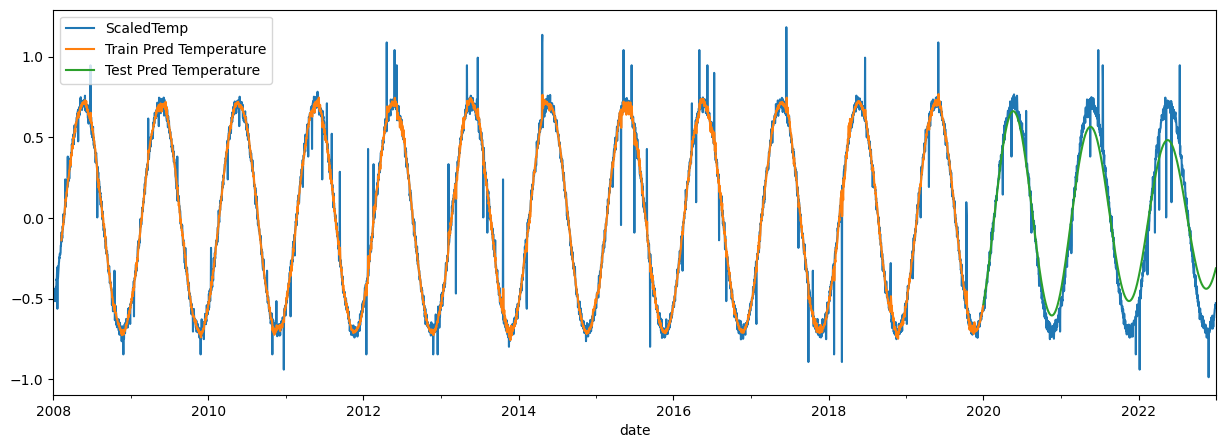

In [15]:
plot_cols = ['ScaledTemp', 'Train Pred Temperature', 'Test Pred Temperature']
df_var[plot_cols].plot(figsize=(15,5))

In [16]:
df_var.loc[train_idx, 'Train Pred Humidity']=fitted_model.fittedvalues['ScaledHumid']
df_var.loc[test_idx, 'Test Pred Humidity']=predict[:,1]

<AxesSubplot: xlabel='date'>

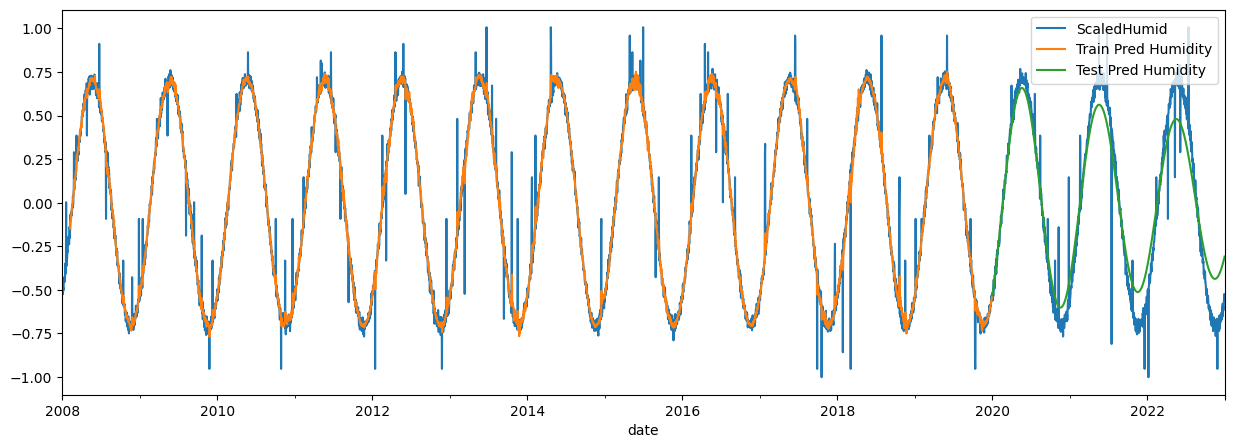

In [17]:
plot_cols = ['ScaledHumid', 'Train Pred Humidity', 'Test Pred Humidity']
df_var[plot_cols].plot(figsize=(15,5))

In [18]:
df_var.loc[train_idx, 'Train Pred Pressure']=fitted_model.fittedvalues['ScaledPressure']
df_var.loc[test_idx, 'Test Pred Pressure']=predict[:,2]

<AxesSubplot: xlabel='date'>

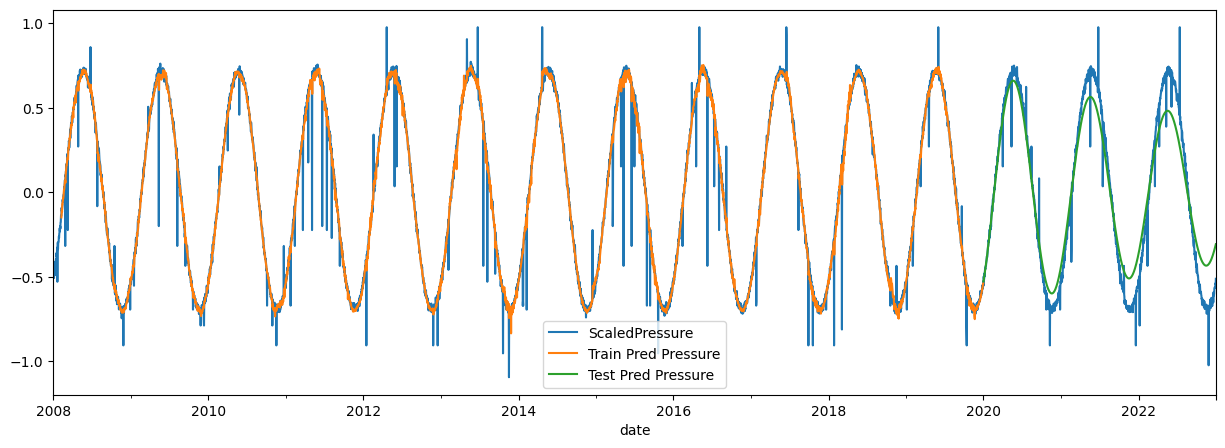

In [19]:
plot_cols = ['ScaledPressure', 'Train Pred Pressure', 'Test Pred Pressure']
df_var[plot_cols].plot(figsize=(15,5))

### Model with extended lag

In [27]:
# Not on same scale and need to split the data to the train and test part 
Ntest = 1096  # 3 year
train= df_var.iloc[:-Ntest].copy()
test= df_var.iloc[-Ntest:].copy()

scaler_temp= RobustScaler()
train['ScaledTemp'] = scaler_temp.fit_transform(train[['temperature']])
test['ScaledTemp'] = scaler_temp.transform(test[['temperature']])

scaler_humid= RobustScaler()
train['ScaledHumid'] = scaler_humid.fit_transform(train[['humidity']])
test['ScaledHumid'] = scaler_humid.transform(test[['humidity']])

scaler_pressure= RobustScaler()
train['ScaledPressure'] = scaler_pressure.fit_transform(train[['pressure']])
test['ScaledPressure'] = scaler_pressure.transform(test[['pressure']])

train_idx = df_var.index <=train.index[-1]
test_idx = df_var.index > train.index[-1]

df_var.loc[train_idx, 'ScaledTemp']= train['ScaledTemp']
df_var.loc[test_idx, 'ScaledTemp']= test['ScaledTemp']

df_var.loc[train_idx, 'ScaledHumid']= train['ScaledHumid']
df_var.loc[test_idx, 'ScaledHumid']= test['ScaledHumid']

df_var.loc[train_idx, 'ScaledPressure']= train['ScaledPressure']
df_var.loc[test_idx, 'ScaledPressure']= test['ScaledPressure']

In [28]:
model_extended=VAR(train[cols])

C:\Users\USER\anaconda3\envs\thesiswork\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


In [29]:
sorted_order=model_extended.select_order(maxlags=200)
print(sorted_order.summary())

  VAR Order Selection (* highlights the minimums)  
        AIC         BIC         FPE         HQIC   
---------------------------------------------------
0        -11.55      -11.54   9.676e-06      -11.54
1        -15.91      -15.90   1.227e-07      -15.91
2        -16.11      -16.08   1.007e-07      -16.10
3        -16.16     -16.12*   9.565e-08      -16.15
4        -16.17      -16.11   9.478e-08      -16.15
5        -16.17      -16.10   9.507e-08      -16.14
6        -16.17      -16.08   9.538e-08      -16.13
7        -16.17      -16.07   9.500e-08      -16.13
8        -16.18      -16.07   9.397e-08      -16.14
9        -16.19      -16.06   9.307e-08      -16.14
10       -16.20      -16.06   9.179e-08      -16.15
11       -16.22      -16.06   9.073e-08      -16.16
12       -16.23      -16.06   8.941e-08      -16.17
13       -16.24      -16.06   8.814e-08      -16.18
14       -16.25      -16.06   8.732e-08      -16.18
15       -16.27      -16.06   8.592e-08      -16.20
16       -16

In [ ]:
#Observation: fitted with 50 lag and with 3 year test data. So, with higher lag the model is a bit stronger and the damping effect is a bit lower.

In [30]:
var_model_extended=VAR(train[cols])
fitted_model_extended=var_model_extended.fit(maxlags=50)
print(fitted_model_extended.summary())

C:\Users\USER\anaconda3\envs\thesiswork\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Thu, 06, Apr, 2023
Time:                     06:10:19
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                   -15.7330
Nobs:                     4333.00    HQIC:                  -16.1642
Log likelihood:           17537.6    FPE:                7.54850e-08
AIC:                     -16.3994    Det(Omega_mle):     6.81130e-08
--------------------------------------------------------------------
Results for equation ScaledTemp
                        coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------------------
const                     -0.000670         0.000954           -0.702           0.483
L1.ScaledTemp              0.138949         0.016383            8.481           0.000
L1.ScaledHumid             0.010502

In [31]:
fcast=fitted_model_extended.forecast(y = train[cols].values[-50:], steps= Ntest)

In [32]:
df_var.loc[train_idx, 'Train Pred Temperature']=fitted_model_extended.fittedvalues['ScaledTemp']
df_var.loc[test_idx, 'Test Pred Temperature']=fcast[:,0]

<AxesSubplot: xlabel='date'>

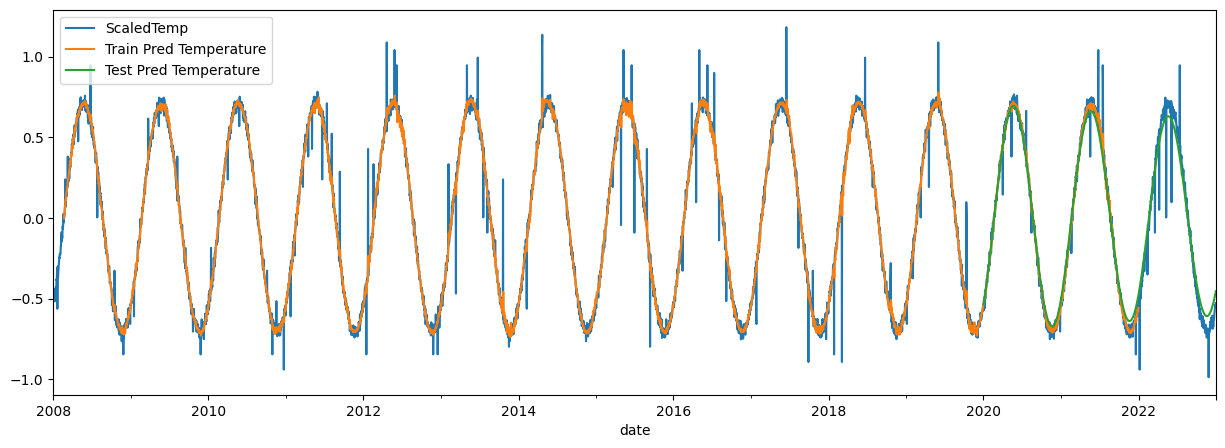

In [33]:
plot_cols = ['ScaledTemp', 'Train Pred Temperature', 'Test Pred Temperature']
df_var[plot_cols].plot(figsize=(15,5))